In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import gc
import sys
import warnings
warnings.filterwarnings("ignore")

In [2]:
# uplod kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saeidehnajafzadeh","key":"6288d0f09353bef35d879717fb5a1834"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c bosch-production-line-performance


 86% 587M/680M [00:00<00:00, 1.22GB/s]
100% 680M/680M [00:00<00:00, 1.22GB/s]


In [5]:
!unzip bosch-production-line-performance.zip -d bosch_data


Archive:  bosch-production-line-performance.zip
  inflating: bosch_data/sample_submission.csv.zip  
  inflating: bosch_data/test_categorical.csv.zip  
  inflating: bosch_data/test_date.csv.zip  
  inflating: bosch_data/test_numeric.csv.zip  
  inflating: bosch_data/train_categorical.csv.zip  
  inflating: bosch_data/train_date.csv.zip  
  inflating: bosch_data/train_numeric.csv.zip  


In [6]:
date = pd.read_csv('bosch_data/train_date.csv.zip')
numeric = pd.read_csv('bosch_data/train_numeric.csv.zip')
category = pd.read_csv('bosch_data/train_categorical.csv.zip')

print(date.shape, numeric.shape, category.shape)

(1183747, 1157) (1183747, 970) (1183747, 2141)


Balanced 1:1 Bosch Dataset

Balanced 1:3 Bosch Dataset

In [7]:
# Separate all class 1 and class 0 rows
class_1_df = numeric[numeric["Response"] == 1]
class_0_df = numeric[numeric["Response"] == 0]

print(f"Class 1 samples: {len(class_1_df)}")
print(f"Class 0 samples: {len(class_0_df)}")

# Version 1: 1:1 balance
class_0_balanced_1to1 = class_0_df.sample(n=len(class_1_df), random_state=42)
ids_1to1 = pd.concat([class_1_df["Id"], class_0_balanced_1to1["Id"]])

# Version 2: 1:3 balance
n_class_0_1to3 = 3 * len(class_1_df)
class_0_balanced_1to3 = class_0_df.sample(n=n_class_0_1to3, random_state=42)
ids_1to3 = pd.concat([class_1_df["Id"], class_0_balanced_1to3["Id"]])

# Filter all datasets by Id
def filter_by_ids(df, ids):
    return df[df["Id"].isin(ids)]

# Filter for 1:1
numeric_1to1 = filter_by_ids(numeric, ids_1to1)
date_1to1 = filter_by_ids(date, ids_1to1)
category_1to1 = filter_by_ids(category, ids_1to1)

# Filter for 1:3
numeric_1to3 = filter_by_ids(numeric, ids_1to3)
date_1to3 = filter_by_ids(date, ids_1to3)
category_1to3 = filter_by_ids(category, ids_1to3)

# Print final shapes
print("\n 1:1 balanced version:")
print("Numeric:", numeric_1to1.shape)
print("Date:", date_1to1.shape)
print("Category:", category_1to1.shape)

print("\n 1:3 version:")
print("Numeric:", numeric_1to3.shape)
print("Date:", date_1to3.shape)
print("Category:", category_1to3.shape)


Class 1 samples: 6879
Class 0 samples: 1176868

📦 1:1 balanced version:
Numeric: (13758, 970)
Date: (13758, 1157)
Category: (13758, 2141)

📦 1:3 version:
Numeric: (27516, 970)
Date: (27516, 1157)
Category: (27516, 2141)


Clean missing values (numerical)



Drop high-NaN and constant columns

In [8]:
# Drop columns with >90% missing
nan_ratio = numeric_1to1.isnull().mean()
high_nan_cols = nan_ratio[nan_ratio > 0.9].index
numeric_1to1_clean = numeric_1to1.drop(columns=high_nan_cols)

# Drop columns with only 1 unique value
unique_counts = numeric_1to1_clean.nunique()
constant_cols = unique_counts[unique_counts == 1].index
numeric_1to1_clean = numeric_1to1_clean.drop(columns=constant_cols)

print("Cleaned numeric shape:", numeric_1to1_clean.shape)


Cleaned numeric shape: (13758, 306)


Encode categorical features -  with one-hot (category)


In [9]:
#  Drop columns with too many missing values
nan_ratio_cat = category_1to1.isnull().mean()
category_1to1_clean = category_1to1.drop(columns=nan_ratio_cat[nan_ratio_cat > 0.9].index)

# Drop low-variance columns (only 1 unique value)
unique_counts_cat = category_1to1_clean.nunique()
category_1to1_clean = category_1to1_clean.drop(columns=unique_counts_cat[unique_counts_cat == 1].index)

# Fill remaining NaNs with 'missing'
category_1to1_clean = category_1to1_clean.fillna("missing")

# Drop 'Id' column
category_1to1_features = category_1to1_clean.drop(columns=["Id"])

# Apply one-hot encoding
category_1to1_encoded = pd.get_dummies(category_1to1_features, drop_first=True)

print("Encoded categorical shape:", category_1to1_encoded.shape)


Encoded categorical shape: (13758, 16)


 Merge numeric and categorical features

In [10]:
# Drop Id and Response from numeric
numeric_features = numeric_1to1_clean.drop(columns=["Id", "Response"])

# Merge on row index (since both dataframes are aligned)
X = pd.concat([numeric_features.reset_index(drop=True), category_1to1_encoded.reset_index(drop=True)], axis=1)
y = numeric_1to1_clean["Response"].values

print("Final feature matrix shape:", X.shape)


Final feature matrix shape: (13758, 320)


Add summary features from date



In [11]:
# Drop Id column
date_only = date_1to1.drop(columns=["Id"])

# Extract min, max, and duration per row
start_time = date_only.min(axis=1)
end_time = date_only.max(axis=1)
duration = end_time - start_time

# Create a new dataframe
date_summary = pd.DataFrame({
    "start_time": start_time,
    "end_time": end_time,
    "duration": duration
})

# Combine with existing X
X = pd.concat([X.reset_index(drop=True), date_summary.reset_index(drop=True)], axis=1)

print("🔧 Final feature matrix shape with date:", X.shape)


🔧 Final feature matrix shape with date: (13758, 323)


Train XGBoost on full feature set

In [13]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 MB 3.4 MB/s eta 0:00:00


In [14]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train XGBoost
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)

# Evaluate
y_pred = xgb.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


[[962 414]
 [561 815]]
              precision    recall  f1-score   support

           0     0.6316    0.6991    0.6637      1376
           1     0.6631    0.5923    0.6257      1376

    accuracy                         0.6457      2752
   macro avg     0.6474    0.6457    0.6447      2752
weighted avg     0.6474    0.6457    0.6447      2752



Plot XGBoost Feature Importance

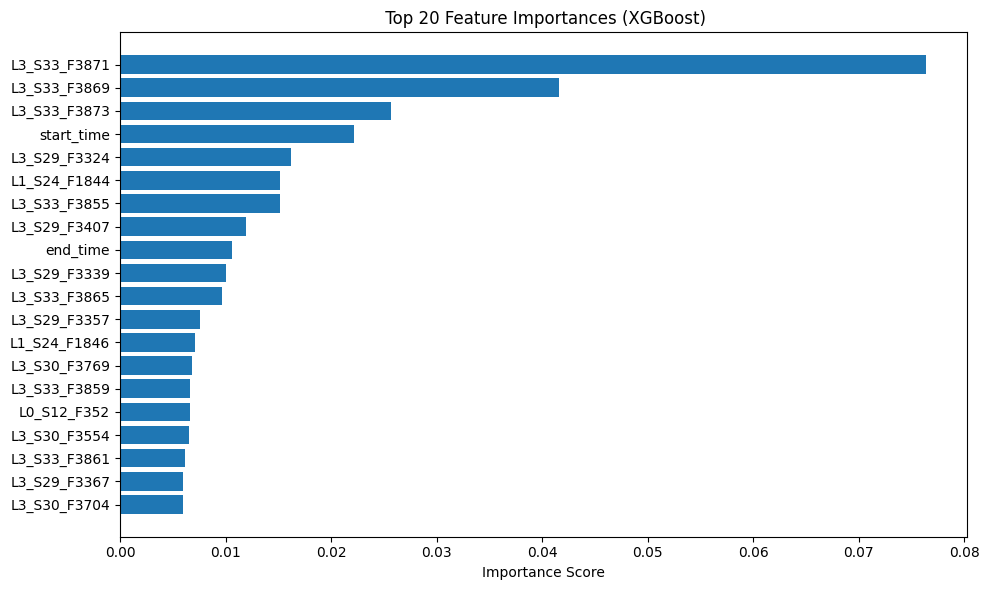

In [16]:
import matplotlib.pyplot as plt

# Get feature importance scores from trained XGBoost model
importances = xgb.feature_importances_

# Create a dataframe for easy plotting
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20][::-1], importance_df['Importance'][:20][::-1])
plt.xlabel('Importance Score')
plt.title(' Top 20 Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()


Select top 10 important features

In [17]:
top_10_features = importance_df['Feature'].iloc[:10].tolist()

# Create a new X with only those features
X_top10 = X[top_10_features]

print("Top 10 features:", top_10_features)
print("X_top10 shape:", X_top10.shape)

Top 10 features: ['L3_S33_F3871', 'L3_S33_F3869', 'L3_S33_F3873', 'start_time', 'L3_S29_F3324', 'L1_S24_F1844', 'L3_S33_F3855', 'L3_S29_F3407', 'end_time', 'L3_S29_F3339']
X_top10 shape: (13758, 10)


Train XGBoost on top 10 features

In [18]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_top10, y, test_size=0.2, stratify=y, random_state=42
)

# Train XGBoost
xgb_top10 = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_top10.fit(X_train, y_train)

# Evaluate
y_pred_top10 = xgb_top10.predict(X_test)
print(confusion_matrix(y_test, y_pred_top10))
print(classification_report(y_test, y_pred_top10, digits=4))


[[958 418]
 [554 822]]
              precision    recall  f1-score   support

           0     0.6336    0.6962    0.6634      1376
           1     0.6629    0.5974    0.6284      1376

    accuracy                         0.6468      2752
   macro avg     0.6483    0.6468    0.6459      2752
weighted avg     0.6483    0.6468    0.6459      2752



Grid Search for XGBoost Hyperparameters

In [19]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Smaller param grid to keep it fast
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150]
}

# Base model
xgb_model = XGBClassifier(
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Run GridSearchCV (3-fold cross-validation)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_top10, y)

# Best params
print(" Best parameters found:", grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
 Best parameters found: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}


Train final tuned XGBoost model

In [20]:
xgb_final = XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=50,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Split again for final test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_top10, y, test_size=0.2, stratify=y, random_state=42
)

# Train
xgb_final.fit(X_train, y_train)

# Predict and evaluate
from sklearn.metrics import classification_report, confusion_matrix

y_pred = xgb_final.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


[[689 687]
 [385 991]]
              precision    recall  f1-score   support

           0     0.6415    0.5007    0.5624      1376
           1     0.5906    0.7202    0.6490      1376

    accuracy                         0.6105      2752
   macro avg     0.6161    0.6105    0.6057      2752
weighted avg     0.6161    0.6105    0.6057      2752




Although the overall accuracy dropped, the tuned model is significantly better at identifying defective products (class 1), which is often the primary business goal in industrial failure detection tasks such as the Bosch Production Line challenge.

Conclusion:

Prioritizing recall over accuracy is a valid trade-off in this context, as missing a defective item can be far more costly than falsely flagging a good one.



Save trained XGBoost model and selected features



In [22]:
import joblib

# Save the trained model
joblib.dump(xgb_final, "xgb_top10_balanced_model.joblib")

# Save the top 10 feature names
with open("top_10_features.txt", "w") as f:
    for feature in top_10_features:
        f.write(feature + "\n")

print(" Model and feature list saved successfully!")


 Model and feature list saved successfully!
